In [3]:
import pandas as pd
import numpy as np
import glob

# 지역별로 나누어진 심각도 데이터 한꺼번에 불러서 통합하기

In [4]:
path = r'C:\Users\user\Jupyter Notebook\최종데이터' # 데이터 들어있는 폴더 위치
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,encoding='cp949')
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True) # 데이터 한꺼번에 병합 완료

In [5]:
frame.to_csv('심각도_전국통합.csv',encoding='cp949')

In [6]:
df = frame # 원본은 'frame'이라는 변수에 남겨두겠음

---

# 데이터 전처리

### 1. 연령 컬럼 전처리
####    - 나중에 연령을 65세 이상만 가져오려면 속성들이 int여야 하는데 지금 str형태라서 처리를 해줘야함

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116035 entries, 0 to 1116034
Data columns (total 58 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   사고번호          1116035 non-null  int64 
 1   발생일시          1116035 non-null  int64 
 2   발생지_시도        1116035 non-null  object
 3   발생지_시군구       1116035 non-null  object
 4   법정동코드         1116035 non-null  int64 
 5   요일            1116035 non-null  object
 6   주야            1116035 non-null  object
 7   사고내용          1116035 non-null  object
 8   사고유형_대분류      1116035 non-null  object
 9   사고유형_중분류      1116035 non-null  object
 10  사고유형          1116035 non-null  object
 11  가해자성별         1116035 non-null  object
 12  피해자성별         1116035 non-null  object
 13  연령가해자         1116035 non-null  object
 14  연령피해자         1116035 non-null  object
 15  가해자음주_대분류     1116035 non-null  object
 16  가해자음주         1116035 non-null  object
 17  보호장구가해자_대분류   1116035 non-null  object
 18  보호

In [8]:
df["연령피해자"]=df["연령피해자"].str.replace("세","") 
df["연령피해자"]=df["연령피해자"].str.replace("불명","0")   
df["연령피해자"]=df["연령피해자"].str.replace("없음","0")

In [9]:
df = df.astype({'연령피해자': 'int'})

### 2. 사고유형 - 차대사람 , 연령 - 65세 이상 만 가져오기

In [10]:
df=df[df['연령피해자']>=65]
df=df[df['사고유형_대분류']=='차대사람']

### 3. 필요없는 컬럼 삭제하기
####    - 대분류,중분류 가 포함되는 컬럼은 일단 다 삭제
####    - 사고번호, 발생일시, 발생지_시도, 발생지_시군구, 법정동코드, 사고위치폴리곤도 삭제

In [11]:
col = df.columns
del_list = []
for i in range(len(col)):
    c =col[i]
    if c[-2:] == "분류":
        del_list.append(c)
del_list      # 일단 대분류,중분류가 포함된 컬럼은 삭제할 예정이라 대분류,중분류가 포함된 컬럼명 뽑아봄

['사고유형_대분류',
 '사고유형_중분류',
 '가해자음주_대분류',
 '보호장구가해자_대분류',
 '보호장구피해자_대분류',
 '행동유형가해자_대분류',
 '행동유형가해자_중분류',
 '당사자종별가해자_대분류',
 '당사자종별피해자_대분류',
 '차량용도가해자_대분류',
 '차량용도가해자_중분류',
 '차량용도피해자_대분류',
 '차량용도피해자_중분류',
 '도로형태_대분류',
 '도로선형_대분류',
 '도로선형_중분류',
 '노면상태_대분류',
 '교차로형태_대분류']

In [12]:
df= df.drop(['사고유형_대분류','사고유형_중분류','가해자음주_대분류','보호장구가해자_대분류','보호장구피해자_대분류','행동유형가해자_대분류','행동유형가해자_중분류'
                 ,'당사자종별피해자_대분류','당사자종별가해자_대분류','차량용도가해자_대분류','차량용도가해자_중분류','차량용도피해자_대분류','차량용도피해자_중분류'
                 ,'도로형태_대분류','도로선형_대분류','도로선형_중분류','노면상태_대분류','교차로형태_대분류','사고위치폴리곤'
                , '사고번호','법정동코드','발생일시','발생지_시도','발생지_시군구'],axis=1)

### 4. [사고심각도] 컬럼 추가하기 다시말해  종속변수 컬럼을 추가하는 것
####    - 이때 사고 심각도는 한 사고당 (273x사망자수)+(32x중상자수)+(2x경상자수)+(1x부상신고) 로 계산하는 것임 => 이 것이 EPDO 임

In [13]:
df

,요일,주야,사고내용,사고유형,가해자성별,피해자성별,연령가해자,연령피해자,가해자음주,보호장구가해자,...,어린이보호구역_여부,자전거도로_여부,도로선형,기상상태,노면상태,교차로형태,사망자수,중상자수,경상자수,부상신고자수
19,화,주,경상,보도통행중,여,여,18세,68,기타불명,미착용,...,아니오,아니오,평지,맑음,서리/결빙,교차로아님,0,0,1,0
34,토,주,중상,횡단중,남,여,80세,75,기타불명,착용불명,...,아니오,아니오,평지,맑음,건조,교차로아님,0,1,0,0
61,목,야,경상,길가장자리구역통행중,남,남,18세,68,기타불명,착용,...,아니오,아니오,평지,맑음,건조,교차로아님,0,0,1,0
76,목,주,중상,길가장자리구역통행중,남,여,22세,89,기타불명,착용불명,...,아니오,아니오,평지,맑음,건조,교차로아님,0,1,0,0
77,목,주,중상,횡단중,여,여,45세,85,기타불명,착용불명,...,아니오,아니오,평지,맑음,건조,교차로아님,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115751,월,주,경상,길가장자리구역통행중,여,여,53세,65,기타불명,착용불명,...,아니오,아니오,평지,맑음,건조,교차로아님,0,0,1,0
1115812,금,주,경상,보도통행중,여,남,28세,71,해당 없음,착용,...,아니오,아니오,평지,맑음,건조,교차로 - 삼지,0,0,1,0
1115826,금,주,중상,차도통행중,여,남,32세,76,해당 없음,착용,...,아니오,아니오,평지,맑음,건조,교차로아님,0,1,0,0
1115835,토,주,중상,기타,남,여,75세,77,해당 없음,착용,...,아니오,아니오,평지,맑음,건조,교차로아님,0,1,0,0


In [14]:
df.info()  # 컬럼명 :사망자수는 30번째

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58059 entries, 19 to 1115843
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   요일          58059 non-null  object
 1   주야          58059 non-null  object
 2   사고내용        58059 non-null  object
 3   사고유형        58059 non-null  object
 4   가해자성별       58059 non-null  object
 5   피해자성별       58059 non-null  object
 6   연령가해자       58059 non-null  object
 7   연령피해자       58059 non-null  int32 
 8   가해자음주       58059 non-null  object
 9   보호장구가해자     58059 non-null  object
 10  보호장구피해자     58059 non-null  object
 11  법규위반가해자     58059 non-null  object
 12  행동유형가해자     58059 non-null  object
 13  신체상해정도가해자   58059 non-null  object
 14  신체상해정도피해자   58059 non-null  object
 15  가해자신체상해주부위  58059 non-null  object
 16  피해자신체상해주부위  58059 non-null  object
 17  당사자종별가해자    58059 non-null  object
 18  당사자종별피해자    58059 non-null  object
 19  차량용도가해자     58059 non-null  object
 20  차량용

In [15]:
사고심각도 =[];
for i in range(len(df)):
    y = (273*df.iloc[i,30])+(32*df.iloc[i,31])+(2*df.iloc[i,32])+(1*df.iloc[i,33])
    사고심각도.append(y)

#### 계산 완료된 사고심각도 값을 데이터프레임에 추가하기

In [16]:
df['사고심각도'] = 사고심각도
df

,요일,주야,사고내용,사고유형,가해자성별,피해자성별,연령가해자,연령피해자,가해자음주,보호장구가해자,...,자전거도로_여부,도로선형,기상상태,노면상태,교차로형태,사망자수,중상자수,경상자수,부상신고자수,사고심각도
19,화,주,경상,보도통행중,여,여,18세,68,기타불명,미착용,...,아니오,평지,맑음,서리/결빙,교차로아님,0,0,1,0,2
34,토,주,중상,횡단중,남,여,80세,75,기타불명,착용불명,...,아니오,평지,맑음,건조,교차로아님,0,1,0,0,32
61,목,야,경상,길가장자리구역통행중,남,남,18세,68,기타불명,착용,...,아니오,평지,맑음,건조,교차로아님,0,0,1,0,2
76,목,주,중상,길가장자리구역통행중,남,여,22세,89,기타불명,착용불명,...,아니오,평지,맑음,건조,교차로아님,0,1,0,0,32
77,목,주,중상,횡단중,여,여,45세,85,기타불명,착용불명,...,아니오,평지,맑음,건조,교차로아님,0,1,0,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115751,월,주,경상,길가장자리구역통행중,여,여,53세,65,기타불명,착용불명,...,아니오,평지,맑음,건조,교차로아님,0,0,1,0,2
1115812,금,주,경상,보도통행중,여,남,28세,71,해당 없음,착용,...,아니오,평지,맑음,건조,교차로 - 삼지,0,0,1,0,2
1115826,금,주,중상,차도통행중,여,남,32세,76,해당 없음,착용,...,아니오,평지,맑음,건조,교차로아님,0,1,0,0,32
1115835,토,주,중상,기타,남,여,75세,77,해당 없음,착용,...,아니오,평지,맑음,건조,교차로아님,0,1,0,0,32


#### df에서 사망,중상,경상,부상신고자 수를 지우고 data라는 변수에 저장

In [17]:
data = df.drop(['사망자수','중상자수','경상자수','부상신고자수'],axis=1) # 원본은 'df'라는 변수에 남겨두겠음

---

####  frame => 통합 원본 데이터 
####  df => 차대사람,65세이상,사고심각도 등 1차 전처리 원본 
####  data => df에서 사망,중상,경상 제외하고 저장

---

# 명목형 변수 가변수(더미변수)로 바꾸기

### 1. 독립변수와 종속변수 데이터 나누기


In [18]:
data_x=data.drop(['사고심각도'],axis=1)   # 종속변수를 제외한 나머지를 독립변수(data_x)로 쓸 예정

data_y=data['사고심각도'] # 종속변수(사고심각도)는 data_y에 저장

### 2. 독립변수 더미변수로 바꾸기

In [19]:
data_x_dum = pd.get_dummies(data_x)  # data_x 를 더미변수로 바꿈
data_x_dum # 원래 숫자형태였던 데이터는 안바뀌고 나머지 범주형 변수들만 바뀐 것을 알 수 있음

,연령피해자,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,주야_야,주야_주,...,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,교차로형태_교차로 - 사지,교차로형태_교차로 - 삼지,교차로형태_교차로 - 오지이상,교차로형태_교차로 - 회전,교차로형태_교차로아님,교차로형태_기타불명
19,68,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
34,75,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
61,68,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
76,89,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
77,85,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115751,65,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115812,71,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1115826,76,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115835,77,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


---

# 상관분석

In [20]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [21]:
# 한글 폰트 깨지는 것 때문에 추가함
import matplotlib
from matplotlib import font_manager, rc
import platform

matplotlib.rcParams['axes.unicode_minus'] = False

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

---

#### result => 문자 데이터 처리하고 사고 심각도 추가된 최종 데이터 셋

---

In [22]:
copy = data_x_dum
copy['사고심각도']= data_y
result = copy
result

,연령피해자,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,주야_야,주야_주,...,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,교차로형태_교차로 - 사지,교차로형태_교차로 - 삼지,교차로형태_교차로 - 오지이상,교차로형태_교차로 - 회전,교차로형태_교차로아님,교차로형태_기타불명,사고심각도
19,68,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,2
34,75,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,32
61,68,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2
76,89,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,32
77,85,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115751,65,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,2
1115812,71,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,2
1115826,76,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,32
1115835,77,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,32


In [23]:
cor_data = result.corr()

In [24]:
cor_data.to_csv('상관계수_전국.csv',encoding='cp949')  # 상관계수 산출물 출력

### 상관행렬 그리기

<AxesSubplot:>

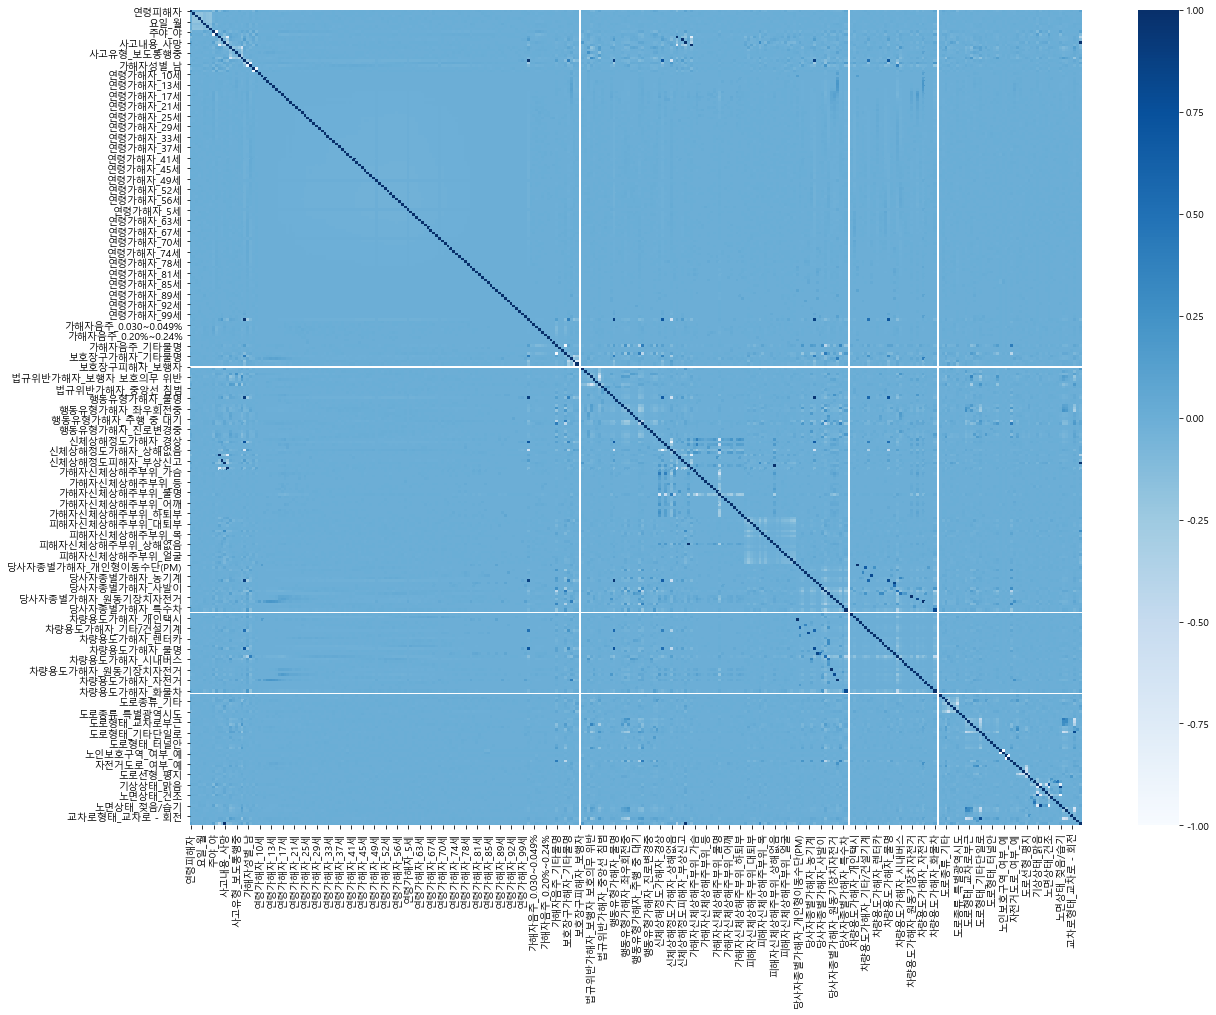

In [25]:
plt.figure(figsize=(20,15))
sns.heatmap(cor_data, cbar = True, annot = False, square = False, cmap = 'Blues')

#### 상관계수가 0.2 이상인 것 뽑아봄

In [26]:
a = cor_data['사고심각도']
for i in range(len(a)):
    if a[i]>=0.2 and a[i]!=1:
        print(a[i])

0.969786386869031
0.968012231854766
0.27929185637631004


# LinearRegression

In [27]:
result_x =result.drop(['사고심각도'],axis=1)
result_x

,연령피해자,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,주야_야,주야_주,...,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,교차로형태_교차로 - 사지,교차로형태_교차로 - 삼지,교차로형태_교차로 - 오지이상,교차로형태_교차로 - 회전,교차로형태_교차로아님,교차로형태_기타불명
19,68,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
34,75,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
61,68,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
76,89,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
77,85,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115751,65,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115812,71,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1115826,76,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115835,77,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [28]:
result_y = result['사고심각도']
result_y

19          2
34         32
61          2
76         32
77         32
           ..
1115751     2
1115812     2
1115826    32
1115835    32
1115843    32
Name: 사고심각도, Length: 58059, dtype: int64

In [29]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(result_x,result_y)

LinearRegression()

In [30]:
model.score(result_x,result_y)  # R square 값

0.9850502147313982

In [31]:
Col=result_x.columns

In [32]:
check = lambda x : '음의 관계' if x<0 else '양의관계'
for i in range(len(Col)):
    print(Col[i],model.coef_[i],check(model.coef_[i]))
print("상수항은: ", model.intercept_)

연령피해자 -0.015211882669852609 음의 관계
요일_금 0.061906601003435924 양의관계
요일_목 -0.022488255278474867 음의 관계
요일_수 0.05026991629915045 양의관계
요일_월 -0.007308924290807539 음의 관계
요일_일 0.06544820863376088 양의관계
요일_토 -0.05189455894403494 음의 관계
요일_화 -0.095932987407636 음의 관계
주야_야 -0.03921390214099496 음의 관계
주야_주 0.03921390214156961 양의관계
사고내용_경상 -73.59284222930059 음의 관계
사고내용_부상신고 -70.4753529300535 음의 관계
사고내용_사망 189.20003833034718 양의관계
사고내용_중상 -45.13184317097564 음의 관계
사고유형_기타 -0.011769082629003336 음의 관계
사고유형_길가장자리구역통행중 0.24241510791284382 양의관계
사고유형_보도통행중 0.3141640527220484 양의관계
사고유형_차도통행중 -0.18927650645848892 음의 관계
사고유형_횡단중 -0.3555335715455632 음의 관계
가해자성별_기타불명 0.10970031829814486 양의관계
가해자성별_남 -0.0597519826120525 음의 관계
가해자성별_여 -0.04994833569638324 음의 관계
피해자성별_남 -0.00590416739185784 음의 관계
피해자성별_여 0.0059041673898407865 양의관계
연령가해자_10세 0.2782543975379706 양의관계
연령가해자_119세 -0.06441710278291092 음의 관계
연령가해자_11세 0.04920028667198878 양의관계
연령가해자_12세 -0.09709612275447482 음의 관계
연령가해자_13세 0.053752163771753736 양의관계
연령가해자_14세 0.0

---

In [35]:
from statsmodels.api import OLS

ols = OLS(result_y,result_x).fit().summary()
ols

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  사고심각도   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.379e+04
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:41:37   Log-Likelihood:            -2.0510e+05
No. Observations:               58059   AIC:                         4.107e+05
Df Residuals:                   57782   BIC:                         4.132e+05
Df Model:                         276                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
연령피해자                   -0.0152      0.005     -2.810      0.005      -0.026      -0.005
요일_금                     2.0619      0.086     23.978      0.000       1.893       2.230
요일_목                     1.9776      0.088     22.437      0.000       1.805       2.150
요일_수                     2.0503      0.088     23.228      0.000       1.877       2.223
요일_월                     1.9927      0.086     23.295      0.000       1.825       2.160
요일_일                     2.0655      0.109     18.975      0.000       1.852       2.279
요일_토                     1.9481      0.094     20.657      0.000       1.763       2.133
요일_화                     1.9041      0.088     21.530      0.000       1.731       2.077
주야_야                     6.9609      0.113     61.606      0.000       6.739       7.182
주야_주                     7.0394      0.115     61.444      0.000       6.815       7.264
사고내용_경상                -70.0928      0.817    -85.844      0.000     -71.693     -68.492
사고내용_부상신고              -66.9753      1.146    -58.418      0.000     -69.222     -64.728
사고내용_사망                192.7001      1.971     97.772      0.000     188.837     196.563
사고내용_중상                -41.6318      0.823    -50.588      0.000     -43.245     -40.019
사고유형_기타                  2.7883      0.084     33.235      0.000       2.624       2.953
사고유형_길가장자리구역통행중          3.0425      0.124     24.475      0.000       2.799       3.286
사고유형_보도통행중               3.1142      0.157     19.852      0.000       2.807       3.422
사고유형_차도통행중               2.6108      0.110     23.783      0.000       2.396       2.826
사고유형_횡단중                 2.4445      0.082     29.822      0.000       2.284       2.605
가해자성별_기타불명               4.7765      0.905      5.279      0.000       3.003       6.550
가해자성별_남                  4.6070      0.433     10.637      0.000       3.758       5.456
가해자성별_여                  4.6168      0.435     10.605      0.000       3.764       5.470
피해자성별_남                  6.9942      0.112     62.282      0.000       6.774       7.214
피해자성별_여                  7.0061      0.113     62.005      0.000       6.785       7.228
연령가해자_10세                0.4256      1.642      0.259      0.795      -2.793       3.644
연령가해자_119세               0.0830      8.309      0.010      0.992     -16.203      16.369
연령가해자_11세                0.1966      1.708      0.115      0.908      -3.150       3.544
연령가해자_12세                0.0503      1.091      0.046      0.963      -2.089       2.189
연령가해자_13세                0.2011      0.992      0.203      0.839      -1.744       2.146
연령가해자_14세                0.2055      1.072      0.192      0.848      -1.896       2.307
연령가해자_15세                0.9124      0.925      0.987      0.324      -0.900       2.725
연령가해자_16세               -0.1275      0.666     -0.191    

### ols 복사해서 엑셀에 복붙한 후 csv로 출력

In [41]:
P_v = pd.read_csv('./P_values.csv',encoding='cp949')
P_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   col      315 non-null    object 
 1   p_value  311 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [53]:
col=P_v['col']
p = P_v['p_value']

good=[];

for i in range(len(P_v)):
    if p[i]<=0.05:
        good.append(col[i])

good

['연령피해자',
 '요일_금',
 '요일_목',
 '요일_수',
 '요일_월',
 '요일_일',
 '요일_토',
 '요일_화',
 '주야_야',
 '주야_주',
 '사고내용_경상',
 '사고내용_부상신고',
 '사고내용_사망',
 '사고내용_중상',
 '사고유형_기타',
 '사고유형_길가장자리구역통행중',
 '사고유형_보도통행중',
 '사고유형_차도통행중',
 '사고유형_횡단중',
 '가해자성별_기타불명',
 '가해자성별_남',
 '가해자성별_여',
 '피해자성별_남',
 '피해자성별_여',
 '연령가해자_32세',
 '연령가해자_93세',
 '가해자음주_0.030~0.049%',
 '가해자음주_0.15%~0.19%',
 '보호장구가해자_기타불명',
 '보호장구가해자_미착용',
 '보호장구가해자_착용',
 '보호장구가해자_착용불명',
 '보호장구피해자_보행자',
 '법규위반가해자_과속',
 '법규위반가해자_교차로 통행방법 위반',
 '법규위반가해자_기타',
 '법규위반가해자_보행자 보호의무 위반',
 '법규위반가해자_신호위반',
 '법규위반가해자_안전운전 의무 불이행',
 '법규위반가해자_중앙선 침범',
 '행동유형가해자_기타',
 '행동유형가해자_우회전 중',
 '행동유형가해자_좌우회전중',
 '행동유형가해자_좌회전 중',
 '행동유형가해자_직진 중',
 '행동유형가해자_직진중',
 '행동유형가해자_진로변경중',
 '행동유형가해자_후진 중',
 '행동유형가해자_후진중',
 '신체상해정도가해자_경상',
 '신체상해정도가해자_기타불명',
 '신체상해정도가해자_부상신고',
 '신체상해정도가해자_사망',
 '신체상해정도가해자_상해없음',
 '신체상해정도가해자_중상',
 '신체상해정도피해자_부상신고',
 '신체상해정도피해자_사망',
 '신체상해정도피해자_중상',
 '가해자신체상해주부위_가슴',
 '가해자신체상해주부위_기타',
 '가해자신체상해주부위_머리',
 '가해자신체상해주부위_상해없음',
 '가해자신체상해주부위_손',
 '가해자신체상해주부위_얼굴',
 '가해자신

### x들을 good에 있는 컬럼들로만 다시 구성

In [72]:
good_data = result

good_x = good_data[['연령피해자',
 '요일_금',
 '요일_목',
 '요일_수',
 '요일_월',
 '요일_일',
 '요일_토',
 '요일_화',
 '주야_야',
 '주야_주',
 '사고내용_경상',
 '사고내용_부상신고',
 '사고내용_사망',
 '사고내용_중상',
 '사고유형_기타',
 '사고유형_길가장자리구역통행중',
 '사고유형_보도통행중',
 '사고유형_차도통행중',
 '사고유형_횡단중',
 '가해자성별_기타불명',
 '가해자성별_남',
 '가해자성별_여',
 '피해자성별_남',
 '피해자성별_여',
 '연령가해자_32세',
 '연령가해자_93세',
 '가해자음주_0.030~0.049%',
 '가해자음주_0.15%~0.19%',
 '보호장구가해자_기타불명',
 '보호장구가해자_미착용',
 '보호장구가해자_착용',
 '보호장구가해자_착용불명',
 '보호장구피해자_보행자',
 '법규위반가해자_과속',
 '법규위반가해자_교차로 통행방법 위반',
 '법규위반가해자_기타',
 '법규위반가해자_보행자 보호의무 위반',
 '법규위반가해자_신호위반',
 '법규위반가해자_안전운전 의무 불이행',
 '법규위반가해자_중앙선 침범',
 '행동유형가해자_기타',
 '행동유형가해자_우회전 중',
 '행동유형가해자_좌우회전중',
 '행동유형가해자_좌회전 중',
 '행동유형가해자_직진 중',
 '행동유형가해자_직진중',
 '행동유형가해자_진로변경중',
 '행동유형가해자_후진 중',
 '행동유형가해자_후진중',
 '신체상해정도가해자_경상',
 '신체상해정도가해자_기타불명',
 '신체상해정도가해자_부상신고',
 '신체상해정도가해자_사망',
 '신체상해정도가해자_상해없음',
 '신체상해정도가해자_중상',
 '신체상해정도피해자_부상신고',
 '신체상해정도피해자_사망',
 '신체상해정도피해자_중상',
 '가해자신체상해주부위_가슴',
 '가해자신체상해주부위_기타',
 '가해자신체상해주부위_머리',
 '가해자신체상해주부위_상해없음',
 '가해자신체상해주부위_손',
 '가해자신체상해주부위_얼굴',
 '가해자신체상해주부위_없음',
 '가해자신체상해주부위_허리',
 '피해자신체상해주부위_가슴',
 '피해자신체상해주부위_기타',
 '피해자신체상해주부위_대퇴부',
 '피해자신체상해주부위_뒷목',
 '피해자신체상해주부위_등',
 '피해자신체상해주부위_머리',
 '피해자신체상해주부위_목',
 '피해자신체상해주부위_발',
 '피해자신체상해주부위_손',
 '피해자신체상해주부위_어깨',
 '피해자신체상해주부위_얼굴',
 '피해자신체상해주부위_팔',
 '피해자신체상해주부위_하퇴부',
 '피해자신체상해주부위_허리',
 '당사자종별가해자_대형',
 '당사자종별가해자_원동기장치자전거',
 '당사자종별가해자_자전거',
 '당사자종별피해자_보행자',
 '차량용도가해자_원동기장치자전거',
 '차량용도가해자_자전거',
 '차량용도피해자_보행자',
 '도로종류_고속국도',
 '도로종류_기타',
 '도로종류_시도',
 '도로종류_일반국도',
 '도로종류_지방도',
 '도로종류_특별광역시도',
 '도로형태_교차로내',
 '도로형태_교차로부근',
 '도로형태_교차로횡단보도내',
 '도로형태_기타',
 '도로형태_기타/불명',
 '도로형태_기타단일로',
 '도로형태_주차장',
 '도로형태_횡단보도부근',
 '도로형태_횡단보도상',
 '노인보호구역_여부_아니오',
 '노인보호구역_여부_예',
 '어린이보호구역_여부_아니오',
 '어린이보호구역_여부_예',
 '도로선형_기타/서비스구역',
 '도로선형_내리막',
 '도로선형_오르막',
 '도로선형_평지',
 '도로선형_평지',
 '기상상태_기타/불명',
 '기상상태_눈',
 '기상상태_맑음',
 '기상상태_비',
 '기상상태_안개',
 '기상상태_흐림',
 '노면상태_건조',
 '노면상태_기타',
 '노면상태_서리/결빙',
 '노면상태_적설',
 '노면상태_젖음/습기',
 '교차로형태_교차로 - 사지',
 '교차로형태_교차로 - 삼지',
 '교차로형태_교차로 - 오지이상',
 '교차로형태_교차로 - 회전',
 '교차로형태_교차로아님',
 '교차로형태_기타불명']]

good_x

,연령피해자,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,주야_야,주야_주,...,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,교차로형태_교차로 - 사지,교차로형태_교차로 - 삼지,교차로형태_교차로 - 오지이상,교차로형태_교차로 - 회전,교차로형태_교차로아님,교차로형태_기타불명
19,68,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
34,75,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
61,68,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
76,89,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
77,85,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115751,65,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115812,71,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1115826,76,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115835,77,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [71]:
good_y = good_data['사고심각도']
good_y

19          2
34         32
61          2
76         32
77         32
           ..
1115751     2
1115812     2
1115826    32
1115835    32
1115843    32
Name: 사고심각도, Length: 58059, dtype: int64

## 다시 LinearRegresssion

In [74]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(good_x,good_y)

LinearRegression()

In [75]:
model.score(good_x,good_y)  # R square 값

0.9850149029554766

In [76]:
ols = OLS(good_y,good_x).fit().summary()
ols

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  사고심각도   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.560e+04
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:06:05   Log-Likelihood:            -2.0516e+05
No. Observations:               58059   AIC:                         4.105e+05
Df Residuals:                   57951   BIC:                         4.115e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
연령피해자                  -0.0155      0.005     -2.869      0.004      -0.026      -0.005
요일_금                    2.1965      0.088     24.984      0.000       2.024       2.369
요일_목                    2.1172      0.090     23.506      0.000       1.941       2.294
요일_수                    2.1807      0.090     24.201      0.000       2.004       2.357
요일_월                    2.1226      0.088     24.234      0.000       1.951       2.294
요일_일                    2.2085      0.110     20.027      0.000       1.992       2.425
요일_토                    2.0842      0.096     21.684      0.000       1.896       2.273
요일_화                    2.0399      0.090     22.567      0.000       1.863       2.217
주야_야                    7.4418      0.131     56.725      0.000       7.185       7.699
주야_주                    7.5078      0.133     56.350      0.000       7.247       7.769
사고내용_경상               -68.6548      0.767    -89.533      0.000     -70.158     -67.152
사고내용_부상신고             -68.2998      1.103    -61.901      0.000     -70.462     -66.137
사고내용_사망               193.0737      1.986     97.233      0.000     189.182     196.966
사고내용_중상               -41.1696      0.808    -50.973      0.000     -42.753     -39.587
사고유형_기타                 2.9749      0.087     34.210      0.000       2.804       3.145
사고유형_길가장자리구역통행중         3.2497      0.126     25.691      0.000       3.002       3.498
사고유형_보도통행중              3.3032      0.159     20.743      0.000       2.991       3.615
사고유형_차도통행중              2.8043      0.113     24.905      0.000       2.584       3.025
사고유형_횡단중                2.6174      0.086     30.491      0.000       2.449       2.786
가해자성별_기타불명              5.2028      0.248     21.019      0.000       4.718       5.688
가해자성별_남                 4.8617      0.146     33.328      0.000       4.576       5.148
가해자성별_여                 4.8851      0.152     32.188      0.000       4.588       5.183
피해자성별_남                 7.4703      0.131     57.040      0.000       7.214       7.727
피해자성별_여                 7.4793      0.132     56.709      0.000       7.221       7.738
연령가해자_32세               1.0053      0.321      3.130      0.002       0.376       1.635
연령가해자_93세              15.5381      5.868      2.648      0.008       4.036      27.040
가해자음주_0.030~0.049%      5.8336      1.282      4.550      0.000       3.321       8.346
가해자음주_0.15%~0.19%       1.5193      0.574      2.647      0.008       0.394       2.644
보호장구가해자_기타불명            3.7230      0.114     32.790      0.000       3.500       3.946
보호장구가해자_미착용             3.6103      0.173     20.876      0.000       3.271       3.949
보호장구가해자_착용              3.7746      0.095     39.683      0.000       3.588       3.961
보호장구가해자_착용불명            3.8417      0.099     38.685      0.000       3.647       4.036
보호장

---

### 한번 더

In [96]:
P = pd.read_csv('./P_values_2.csv',encoding='cp949')

col=P['col']
p = P['p_value']

good2=[];

for i in range(len(col)):
    if p[i]<=0.05:
        good2.append(col[i])

good2

['연령피해자',
 '요일_금',
 '요일_목',
 '요일_수',
 '요일_월',
 '요일_일',
 '요일_토',
 '요일_화',
 '주야_야',
 '주야_주',
 '사고내용_경상',
 '사고내용_부상신고',
 '사고내용_사망',
 '사고내용_중상',
 '사고유형_기타',
 '사고유형_길가장자리구역통행중',
 '사고유형_보도통행중',
 '사고유형_차도통행중',
 '사고유형_횡단중',
 '가해자성별_기타불명',
 '가해자성별_남',
 '가해자성별_여',
 '피해자성별_남',
 '피해자성별_여',
 '연령가해자_32세',
 '연령가해자_93세',
 '가해자음주_0.030~0.049%',
 '가해자음주_0.15%~0.19%',
 '보호장구가해자_기타불명',
 '보호장구가해자_미착용',
 '보호장구가해자_착용',
 '보호장구가해자_착용불명',
 '보호장구피해자_보행자',
 '법규위반가해자_과속',
 '행동유형가해자_직진 중',
 '행동유형가해자_직진중',
 '행동유형가해자_진로변경중',
 '신체상해정도가해자_경상',
 '신체상해정도가해자_기타불명',
 '신체상해정도가해자_부상신고',
 '신체상해정도가해자_사망',
 '신체상해정도가해자_상해없음',
 '신체상해정도가해자_중상',
 '신체상해정도피해자_사망',
 '신체상해정도피해자_중상',
 '가해자신체상해주부위_가슴',
 '가해자신체상해주부위_기타',
 '가해자신체상해주부위_머리',
 '가해자신체상해주부위_상해없음',
 '가해자신체상해주부위_손',
 '가해자신체상해주부위_얼굴',
 '가해자신체상해주부위_없음',
 '가해자신체상해주부위_허리',
 '피해자신체상해주부위_가슴',
 '피해자신체상해주부위_기타',
 '피해자신체상해주부위_대퇴부',
 '피해자신체상해주부위_뒷목',
 '피해자신체상해주부위_등',
 '피해자신체상해주부위_머리',
 '피해자신체상해주부위_목',
 '피해자신체상해주부위_발',
 '피해자신체상해주부위_손',
 '피해자신체상해주부위_어깨',
 '피해자신체상해주부위_얼굴',
 '피해자신체상해주부위_팔',
 '

In [98]:
good_data2 = good_data
good2_x = good_data2[['연령피해자',
 '요일_금',
 '요일_목',
 '요일_수',
 '요일_월',
 '요일_일',
 '요일_토',
 '요일_화',
 '주야_야',
 '주야_주',
 '사고내용_경상',
 '사고내용_부상신고',
 '사고내용_사망',
 '사고내용_중상',
 '사고유형_기타',
 '사고유형_길가장자리구역통행중',
 '사고유형_보도통행중',
 '사고유형_차도통행중',
 '사고유형_횡단중',
 '가해자성별_기타불명',
 '가해자성별_남',
 '가해자성별_여',
 '피해자성별_남',
 '피해자성별_여',
 '연령가해자_32세',
 '연령가해자_93세',
 '가해자음주_0.030~0.049%',
 '가해자음주_0.15%~0.19%',
 '보호장구가해자_기타불명',
 '보호장구가해자_미착용',
 '보호장구가해자_착용',
 '보호장구가해자_착용불명',
 '보호장구피해자_보행자',
 '법규위반가해자_과속',
 '행동유형가해자_직진 중',
 '행동유형가해자_직진중',
 '행동유형가해자_진로변경중',
 '신체상해정도가해자_경상',
 '신체상해정도가해자_기타불명',
 '신체상해정도가해자_부상신고',
 '신체상해정도가해자_사망',
 '신체상해정도가해자_상해없음',
 '신체상해정도가해자_중상',
 '신체상해정도피해자_사망',
 '신체상해정도피해자_중상',
 '가해자신체상해주부위_가슴',
 '가해자신체상해주부위_기타',
 '가해자신체상해주부위_머리',
 '가해자신체상해주부위_상해없음',
 '가해자신체상해주부위_손',
 '가해자신체상해주부위_얼굴',
 '가해자신체상해주부위_없음',
 '가해자신체상해주부위_허리',
 '피해자신체상해주부위_가슴',
 '피해자신체상해주부위_기타',
 '피해자신체상해주부위_대퇴부',
 '피해자신체상해주부위_뒷목',
 '피해자신체상해주부위_등',
 '피해자신체상해주부위_머리',
 '피해자신체상해주부위_목',
 '피해자신체상해주부위_발',
 '피해자신체상해주부위_손',
 '피해자신체상해주부위_어깨',
 '피해자신체상해주부위_얼굴',
 '피해자신체상해주부위_팔',
 '피해자신체상해주부위_하퇴부',
 '피해자신체상해주부위_허리',
 '당사자종별가해자_자전거',
 '당사자종별피해자_보행자',
 '차량용도가해자_자전거',
 '차량용도피해자_보행자',
 '도로종류_고속국도',
 '도로종류_지방도',
 '도로형태_교차로내',
 '도로형태_교차로부근',
 '도로형태_교차로횡단보도내',
 '노인보호구역_여부_아니오',
 '노인보호구역_여부_예',
 '어린이보호구역_여부_아니오',
 '어린이보호구역_여부_예',
 '도로선형_평지',
 '도로선형_평지',
 '기상상태_기타/불명',
 '기상상태_눈',
 '기상상태_맑음',
 '기상상태_비',
 '기상상태_안개',
 '기상상태_흐림',
 '노면상태_건조',
 '노면상태_기타',
 '노면상태_서리/결빙',
 '노면상태_적설',
 '노면상태_젖음/습기',
 '교차로형태_교차로 - 사지',
 '교차로형태_교차로 - 삼지',
 '교차로형태_교차로 - 오지이상',
 '교차로형태_교차로 - 회전',
 '교차로형태_교차로아님',
 '교차로형태_기타불명']]

good2_x

,연령피해자,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,주야_야,주야_주,...,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,교차로형태_교차로 - 사지,교차로형태_교차로 - 삼지,교차로형태_교차로 - 오지이상,교차로형태_교차로 - 회전,교차로형태_교차로아님,교차로형태_기타불명
19,68,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
34,75,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
61,68,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
76,89,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
77,85,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115751,65,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115812,71,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1115826,76,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1115835,77,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [101]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(good2_x,good_y)
model.score(good2_x,good_y)  # R square 값

0.9849986322806868

In [103]:
ols = OLS(good_y,good2_x).fit().summary()
ols

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  사고심각도   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 4.819e+04
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:23:38   Log-Likelihood:            -2.0520e+05
No. Observations:               58059   AIC:                         4.106e+05
Df Residuals:                   57979   BIC:                         4.113e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
연령피해자                 -0.0182      0.005     -3.393      0.001      -0.029      -0.008
요일_금                   2.2056      0.086     25.785      0.000       2.038       2.373
요일_목                   2.1298      0.087     24.345      0.000       1.958       2.301
요일_수                   2.1900      0.088     24.970      0.000       2.018       2.362
요일_월                   2.1341      0.085     25.103      0.000       1.967       2.301
요일_일                   2.2117      0.108     20.403      0.000       1.999       2.424
요일_토                   2.0930      0.094     22.314      0.000       1.909       2.277
요일_화                   2.0531      0.088     23.345      0.000       1.881       2.225
주야_야                   7.4676      0.109     68.506      0.000       7.254       7.681
주야_주                   7.5496      0.111     67.720      0.000       7.331       7.768
사고내용_경상              -68.3033      0.695    -98.262      0.000     -69.666     -66.941
사고내용_부상신고            -69.2591      0.707    -97.958      0.000     -70.645     -67.873
사고내용_사망              193.4312      1.972     98.097      0.000     189.566     197.296
사고내용_중상              -40.8516      0.767    -53.289      0.000     -42.354     -39.349
사고유형_기타                2.9388      0.081     36.184      0.000       2.780       3.098
사고유형_길가장자리구역통행중        3.1799      0.122     26.053      0.000       2.941       3.419
사고유형_보도통행중             3.4643      0.150     23.063      0.000       3.170       3.759
사고유형_차도통행중             2.7519      0.108     25.565      0.000       2.541       2.963
사고유형_횡단중               2.6823      0.078     34.521      0.000       2.530       2.835
가해자성별_기타불명             5.0849      0.228     22.306      0.000       4.638       5.532
가해자성별_남                4.9557      0.128     38.639      0.000       4.704       5.207
가해자성별_여                4.9765      0.134     37.115      0.000       4.714       5.239
피해자성별_남                7.5023      0.109     69.013      0.000       7.289       7.715
피해자성별_여                7.5149      0.110     68.343      0.000       7.299       7.730
연령가해자_32세              0.9977      0.321      3.107      0.002       0.368       1.627
연령가해자_93세             15.4972      5.869      2.640      0.008       3.994      27.001
가해자음주_0.030~0.049%     5.7908      1.282      4.517      0.000       3.278       8.304
가해자음주_0.15%~0.19%      1.5255      0.574      2.658      0.008       0.401       2.650
보호장구가해자_기타불명           3.7346      0.107     34.825      0.000       3.524       3.945
보호장구가해자_미착용            3.6399      0.168     21.620      0.000       3.310       3.970
보호장구가해자_착용             3.7870      0.088     43.280      0.000       3.615       3.959
보호장구가해자_착용불명           3.8557      0.092     41.919      0.000       3.675       4.036
보호장구피해자_보행자           15.0172      0.2